In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.tsa.stattools as sts

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import time

# Processing

In [2]:
path = '../data/GOOGL_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(path)
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [3]:
# Converting Date column to datetime
df['Date'] = pd.to_datetime(df.Date, yearfirst=True)
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [4]:
df.set_index('Date', inplace=True) # Setting the index to date

df = df.asfreq('b') # Setting the frequency to business days

df.drop('Name', axis=1, inplace=True) # Dropping useless columns

# Checking clusters of NaN and filling NaN

In [5]:
# Create a boolean mask for NaN values
nan_mask = df['Open'].isna()

# Check for consecutive NaN values using the shift() function
consecutive_nan_mask = nan_mask & nan_mask.shift(-1)

consecutive_nan_mask.sum() # Checking how many consecutive nan there are

3

In [6]:
df[(df.index.day < 5) * (df.index.month == 1) * (df.index.year == 2007)]

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-01,NaN,NaN,NaN,NaN,NaN
2007-01-02,NaN,NaN,NaN,NaN,NaN
2007-01-03,233.23,238.57,230.79,234.03,7722839.0
2007-01-04,234.73,242.22,234.41,241.87,7916458.0


In [7]:
df[(df.index.day < 6) * (df.index.month == 4) * (df.index.year == 2010)]

,Open,High,Low,Close,Volume
Date,,,,,
2010-04-01,NaN,NaN,NaN,NaN,NaN
2010-04-02,NaN,NaN,NaN,NaN,NaN
2010-04-05,285.74,287.73,284.78,285.79,1902063.0


In [8]:
df[(df.index.day > 25) * (df.index.month == 10) * (df.index.year == 2012)]

,Open,High,Low,Close,Volume
Date,,,,,
2012-10-26,338.59,341.86,335.94,337.91,1950865.0
2012-10-29,NaN,NaN,NaN,NaN,NaN
2012-10-30,NaN,NaN,NaN,NaN,NaN
2012-10-31,340.27,340.84,337.84,340.49,1537001.0


In [9]:
df[consecutive_nan_mask]

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-01,NaN,NaN,NaN,NaN,NaN
2010-04-01,NaN,NaN,NaN,NaN,NaN
2012-10-29,NaN,NaN,NaN,NaN,NaN


In [10]:
aux = df[consecutive_nan_mask]
df = df[~consecutive_nan_mask]

In [11]:
df = df.fillna(method='bfill') # Backfilling

# Adding the other samples
df = df.asfreq('b')
df = df.fillna(method='ffill') # Sampling them using frontfill

In [12]:
df.isna().sum().sum()

0

In [13]:
input_vars = df.shape[1]

# Normalization

In [14]:
train_size = 0.8
val_size = 0.1
train_samples = int(df.shape[0]*train_size)
val_samples = int(df.shape[0]*(train_size+val_size))

scaler = StandardScaler()
df.iloc[:train_samples] = scaler.fit_transform(df.iloc[:train_samples])
df.iloc[train_samples:] = scaler.transform(df.iloc[train_samples:])

In [15]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,-0.904145,-0.873545,-0.899456,-0.854099,2.876012
2006-01-04,-0.821233,-0.822217,-0.815559,-0.815269,3.550220
2006-01-05,-0.813096,-0.812183,-0.808704,-0.791940,2.149591
2006-01-06,-0.770943,-0.738935,-0.762899,-0.736059,4.322127
2006-01-09,-0.733903,-0.727743,-0.732908,-0.731253,2.769132


# Lagging variables 

In [16]:
n_lagged = 50

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # n_in = number of lagged variables in the past
    # n_out = number of lagged variables in the future
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    col_names = data.columns
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(col_names[j]+'(t-%d)' % (i,)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [col_names[j]+'(t)' for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# frame as supervised learning
reframed = series_to_supervised(df, n_lagged, 1)
# drop columns we don't want to predict
reframed.head()

,Open(t-50),High(t-50),Low(t-50),Close(t-50),Volume(t-50),Open(t-49),High(t-49),Low(t-49),Close(t-49),Volume(t-49),...,Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Open(t),High(t),Low(t),Close(t),Volume(t)
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-14,-0.904145,-0.873545,-0.899456,-0.854099,2.876012,-0.821233,-0.822217,-0.815559,-0.815269,3.550220,...,-1.220530,-1.219563,-1.222191,-1.234880,3.035635,-1.235253,-1.195327,-1.233175,-1.180162,4.542192
2006-03-15,-0.821233,-0.822217,-0.815559,-0.815269,3.550220,-0.813096,-0.812183,-0.808704,-0.791940,2.149591,...,-1.235253,-1.195327,-1.233175,-1.180162,4.542192,-1.182406,-1.195558,-1.202327,-1.206048,2.761922
2006-03-16,-0.813096,-0.812183,-0.808704,-0.791940,2.149591,-0.770943,-0.738935,-0.762899,-0.736059,4.322127,...,-1.182406,-1.195558,-1.202327,-1.206048,2.761922,-1.190775,-1.209297,-1.212609,-1.228292,1.901114
2006-03-17,-0.770943,-0.738935,-0.762899,-0.736059,4.322127,-0.733903,-0.727743,-0.732908,-0.731253,2.769132,...,-1.190775,-1.209297,-1.212609,-1.228292,1.901114,-1.228821,-1.236235,-1.224216,-1.224339,1.443441
2006-03-20,-0.733903,-0.727743,-0.732908,-0.731253,2.769132,-0.741652,-0.739938,-0.728624,-0.720170,1.614286,...,-1.228821,-1.236235,-1.224216,-1.224339,1.443441,-1.215106,-1.204126,-1.198432,-1.191710,2.024490


In [18]:
# At time "t", we only have Open(t) and want to predict Close(t), so we can drop High(t), Volume(t) and Low(t)
# Also we will drop Open(t-1) because each time step needs to have exactly 4 variables. If we add more time steps we will have
# a remaining Variable (Open(t)) to spare, so we will replace Open(t-1) with Open(t) for the first lagged variable.
reframed.drop(['High(t)', 'Low(t)', 'Volume(t)', 'Open(t-'+str(n_lagged)+')'], axis=1, inplace=True)
reframed.head()

,High(t-50),Low(t-50),Close(t-50),Volume(t-50),Open(t-49),High(t-49),Low(t-49),Close(t-49),Volume(t-49),Open(t-48),...,Low(t-2),Close(t-2),Volume(t-2),Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Open(t),Close(t)
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-14,-0.873545,-0.899456,-0.854099,2.876012,-0.821233,-0.822217,-0.815559,-0.815269,3.550220,-0.813096,...,-1.237381,-1.233175,4.815238,-1.220530,-1.219563,-1.222191,-1.234880,3.035635,-1.235253,-1.180162
2006-03-15,-0.822217,-0.815559,-0.815269,3.550220,-0.813096,-0.812183,-0.808704,-0.791940,2.149591,-0.770943,...,-1.222191,-1.234880,3.035635,-1.235253,-1.195327,-1.233175,-1.180162,4.542192,-1.182406,-1.206048
2006-03-16,-0.812183,-0.808704,-0.791940,2.149591,-0.770943,-0.738935,-0.762899,-0.736059,4.322127,-0.733903,...,-1.233175,-1.180162,4.542192,-1.182406,-1.195558,-1.202327,-1.206048,2.761922,-1.190775,-1.228292
2006-03-17,-0.738935,-0.762899,-0.736059,4.322127,-0.733903,-0.727743,-0.732908,-0.731253,2.769132,-0.741652,...,-1.202327,-1.206048,2.761922,-1.190775,-1.209297,-1.212609,-1.228292,1.901114,-1.228821,-1.224339
2006-03-20,-0.727743,-0.732908,-0.731253,2.769132,-0.741652,-0.739938,-0.728624,-0.720170,1.614286,-0.715074,...,-1.212609,-1.228292,1.901114,-1.228821,-1.236235,-1.224216,-1.224339,1.443441,-1.215106,-1.191710


# Data splitting

In [19]:
train_X, train_y = reframed.iloc[:train_samples, :-1].values, reframed.iloc[:train_samples, -1].values
val_X, val_y = reframed.iloc[train_samples:val_samples, :-1].values, reframed.iloc[train_samples:val_samples, -1].values
test_X, test_y = reframed.iloc[val_samples:, :-1].values, reframed.iloc[val_samples:, -1].values

# Reshaping data for LSTM

In [20]:
train_X = train_X.reshape((train_X.shape[0], n_lagged, input_vars))
val_X = val_X.reshape((val_X.shape[0], n_lagged, input_vars))
test_X = test_X.reshape((test_X.shape[0], n_lagged, input_vars))

In [21]:
train_X.shape

(2503, 50, 5)

# LSTM

Epoch 1/100
79/79 - 11s - loss: 0.0284 - val_loss: 0.0496 - 11s/epoch - 145ms/step
Epoch 2/100
79/79 - 9s - loss: 0.0069 - val_loss: 0.0146 - 9s/epoch - 108ms/step
Epoch 3/100
79/79 - 9s - loss: 0.0077 - val_loss: 0.0144 - 9s/epoch - 108ms/step
Epoch 4/100
79/79 - 9s - loss: 0.0059 - val_loss: 0.0114 - 9s/epoch - 114ms/step
Epoch 5/100
79/79 - 9s - loss: 0.0055 - val_loss: 0.0111 - 9s/epoch - 120ms/step
Epoch 6/100
79/79 - 12s - loss: 0.0049 - val_loss: 0.0119 - 12s/epoch - 147ms/step
Epoch 7/100
79/79 - 14s - loss: 0.0045 - val_loss: 0.0128 - 14s/epoch - 181ms/step
Epoch 8/100
79/79 - 13s - loss: 0.0041 - val_loss: 0.0135 - 13s/epoch - 162ms/step
Epoch 9/100
79/79 - 12s - loss: 0.0039 - val_loss: 0.0131 - 12s/epoch - 158ms/step
Epoch 10/100
79/79 - 11s - loss: 0.0037 - val_loss: 0.0115 - 11s/epoch - 142ms/step
Epoch 11/100
79/79 - 12s - loss: 0.0035 - val_loss: 0.0101 - 12s/epoch - 153ms/step
Epoch 12/100
79/79 - 12s - loss: 0.0034 - val_loss: 0.0106 - 12s/epoch - 155ms/step
Epoch 13/

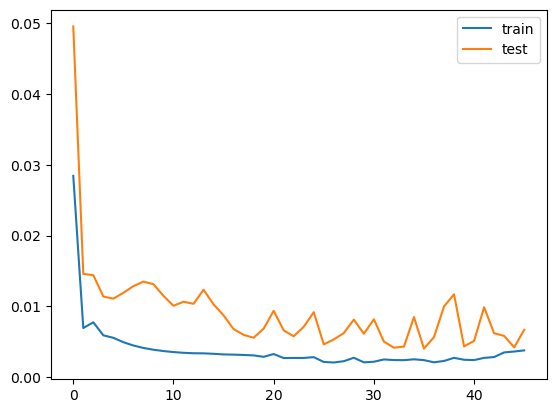

In [28]:
hidden_layer_neurons = 500
batch_size = 32
epochs = 100
learning_rate = 0.0005

# Optimizer and callbacks
optimizer = Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Defining model
model = Sequential()
model.add(LSTM(hidden_layer_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1)) # Output layer
model.compile(loss='mse', optimizer=optimizer)

# Fit network
t0 = time.time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, 
                    validation_data=(val_X, val_y), verbose=2, shuffle=False,
                   callbacks = [early_stopping])
t1 = time.time()
print("Total execution time:", t1-t0)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [57]:
530.13 / 60

8.8355

# Predicting

In [29]:
mean = scaler.mean_[scaler.feature_names_in_ == 'Close'][0]
std = np.sqrt(scaler.var_[scaler.feature_names_in_ == 'Close'][0])

9/9 [==============================] - 0s 42ms/step


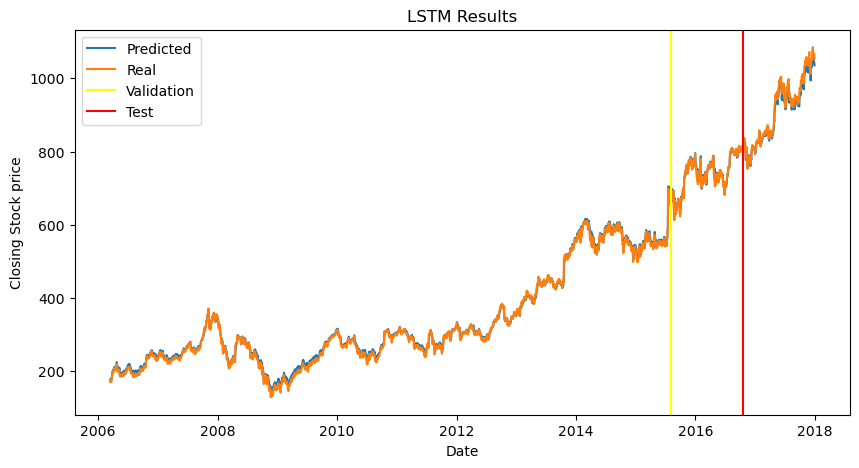

In [30]:
plt.subplots(figsize=(10, 5))

# make a prediction
yhat_train = model.predict(train_X).flatten()
yhat_val = model.predict(val_X).flatten() 
yhat_test = model.predict(test_X).flatten() 

# Concatenate the results
y_pred = np.concatenate([yhat_train, yhat_val, yhat_test])* std + mean
y_real = np.concatenate([train_y, val_y, test_y]) * std + mean

# Plot
plt.plot(df.iloc[n_lagged:].index, y_pred, label='Predicted')
plt.plot(df.iloc[n_lagged:].index, y_real, label='Real')

plt.axvline(x = df.iloc[[train_samples]].index, color = 'yellow', label = 'Validation')
plt.axvline(x = df.iloc[[val_samples]].index, color = 'red', label = 'Test')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock price")
plt.title("LSTM Results")
plt.show()

In [31]:
# Getting metrics
# MSE
train_rmse = np.sqrt( mean_squared_error( y_real[:train_samples], y_pred[:train_samples] ) )
val_rmse = np.sqrt( mean_squared_error( y_real[train_samples:val_samples], y_pred[train_samples:val_samples] ) )
test_rmse = np.sqrt( mean_squared_error( y_real[val_samples:], y_pred[val_samples:] ) )

# MAE
train_mae = mean_absolute_error( y_real[:train_samples], y_pred[:train_samples] )
val_mae = mean_absolute_error( y_real[train_samples:val_samples], y_pred[train_samples:val_samples] )
test_mae = mean_absolute_error( y_real[val_samples:], y_pred[val_samples:] )


In [40]:
print(test_mae, test_rmse)

11.636622903918134 14.105294577315565


In [38]:
print(val_mae, val_rmse)

6.0063638724915105 8.1777655029433


In [37]:
print(train_mae, train_rmse)

5.70725178662558 7.347717243605226


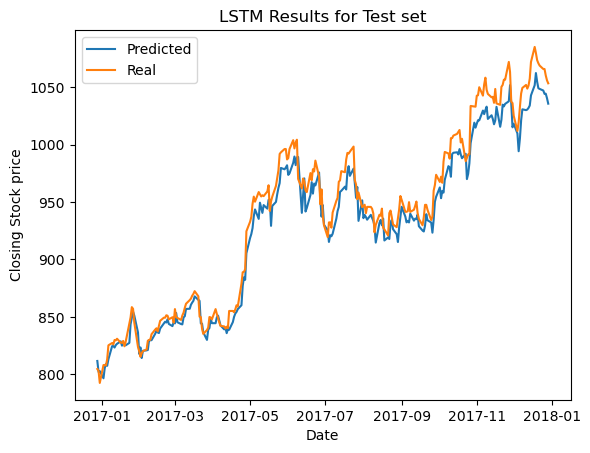

In [35]:
# Plot
plt.plot(df.iloc[n_lagged+val_samples:].index, y_pred[val_samples:], label='Predicted')
plt.plot(df.iloc[n_lagged+val_samples:].index, y_real[val_samples:], label='Real')


plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock price")
plt.title("LSTM Results for Test set")
plt.show()

In [41]:
aux = pd.read_csv(path)

In [55]:
np.mean((aux.iloc[train_samples: val_samples]['Open'] - aux.iloc[train_samples: val_samples]['Close']))

0.28335463258785926

In [56]:
mean_absolute_error(aux.iloc[val_samples:]['Open'] + 0.28, aux.iloc[val_samples:]['Close'])

5.830394088669956

In [58]:
train_samples

2503

# Simple RNN

Epoch 1/50
79/79 [==============================] - 4s 35ms/step - loss: 0.1816 - val_loss: 0.0457
Epoch 2/50
79/79 [==============================] - 3s 32ms/step - loss: 0.0351 - val_loss: 0.0291
Epoch 3/50
79/79 [==============================] - 3s 33ms/step - loss: 0.0199 - val_loss: 0.0338
Epoch 4/50
79/79 [==============================] - 2s 31ms/step - loss: 0.0078 - val_loss: 0.0150
Epoch 5/50
79/79 [==============================] - 3s 34ms/step - loss: 0.0102 - val_loss: 0.0131
Epoch 6/50
79/79 [==============================] - 3s 34ms/step - loss: 0.0064 - val_loss: 0.0109
Epoch 7/50
79/79 [==============================] - 2s 30ms/step - loss: 0.0061 - val_loss: 0.0106
Epoch 8/50
79/79 [==============================] - 2s 29ms/step - loss: 0.0055 - val_loss: 0.0099
Epoch 9/50
79/79 [==============================] - 3s 34ms/step - loss: 0.0049 - val_loss: 0.0092
Epoch 10/50
79/79 [==============================] - 3s 35ms/step - loss: 0.0052 - val_loss: 0.0085
Epoch 11/

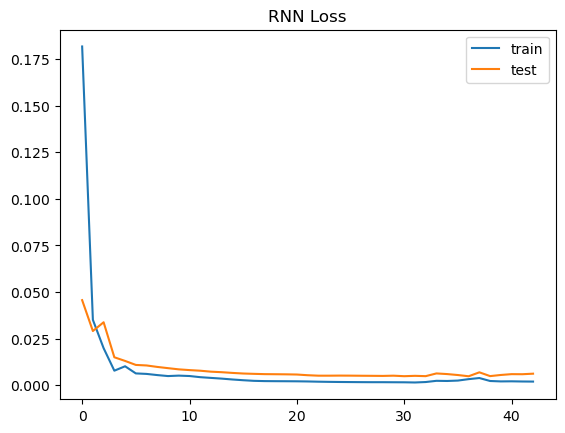

9/9 [==============================] - 0s 12ms/step


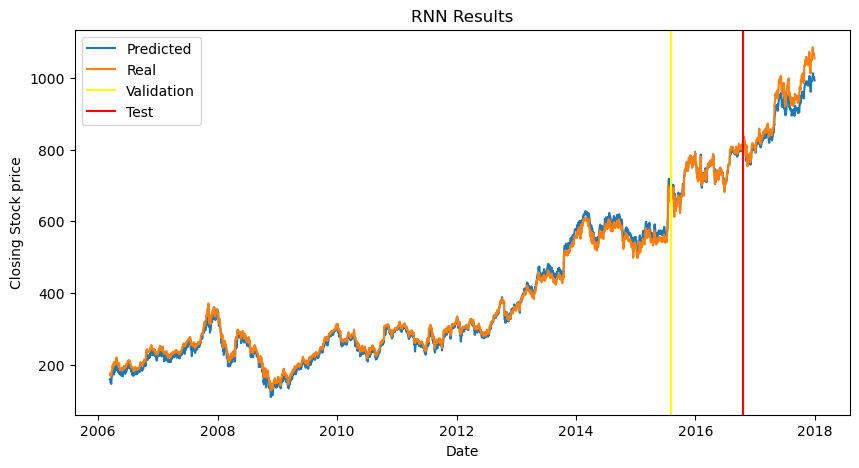

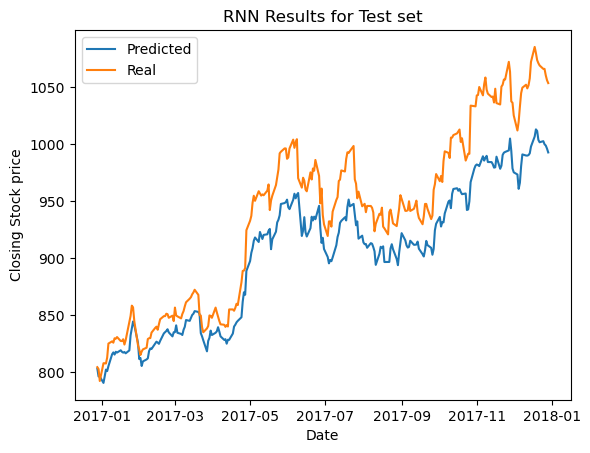

Test RMSE: 38.5491002416011
Test MAE: 33.88787533604147
Validation RMSE: 8.979425204691145
Validation MAE: 7.1240249507038715
Train RMSE: 12.818185071556673
Train MAE: 11.000668703415275


(None, None)

In [59]:
# RNN model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

hidden_layer_neurons = 700
batch_size = 32
epochs = 50
learning_rate = 0.0005

model_rnn = Sequential()
model_rnn.add(SimpleRNN(hidden_layer_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model_rnn.add(Dense(1)) 

# Fit network
t0 = time.time()   

optimizer = Adam(learning_rate=learning_rate)
model_rnn.compile(loss='mse', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history_rnn = model_rnn.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, 
                    validation_data=(val_X, val_y), verbose=1, shuffle=False,
                   callbacks = [early_stopping])
t1 = time.time()
print("Total execution time:", t1-t0)

# Plot history
plt.plot(history_rnn.history['loss'], label='train')
plt.plot(history_rnn.history['val_loss'], label='test')
plt.legend()
plt.title("RNN Loss")
plt.show()

plt.subplots(figsize=(10, 5))

# make a prediction
yhat_train = model_rnn.predict(train_X).flatten()
yhat_val = model_rnn.predict(val_X).flatten()
yhat_test = model_rnn.predict(test_X).flatten()

# Concatenate the results
mean = scaler.mean_[scaler.feature_names_in_ == 'Close'][0]
std = np.sqrt(scaler.var_[scaler.feature_names_in_ == 'Close'][0])
y_pred = np.concatenate([yhat_train, yhat_val, yhat_test])* std + mean
y_real = np.concatenate([train_y, val_y, test_y]) * std + mean

# Plot
plt.plot(df.iloc[n_lagged:].index, y_pred, label='Predicted')
plt.plot(df.iloc[n_lagged:].index, y_real, label='Real')

plt.axvline(x = df.iloc[[train_samples]].index, color = 'yellow', label = 'Validation')
plt.axvline(x = df.iloc[[val_samples]].index, color = 'red', label = 'Test')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock price")
plt.title("RNN Results")
plt.show()

# Getting metrics
# MSE
train_rmse = np.sqrt( mean_squared_error( y_real[:train_samples], y_pred[:train_samples] ) )
val_rmse = np.sqrt( mean_squared_error( y_real[train_samples:val_samples], y_pred[train_samples:val_samples] ) )
test_rmse = np.sqrt( mean_squared_error( y_real[val_samples:], y_pred[val_samples:] ) )

# MAE
train_mae = mean_absolute_error( y_real[:train_samples], y_pred[:train_samples] )
val_mae = mean_absolute_error( y_real[train_samples:val_samples], y_pred[train_samples:val_samples] )
test_mae = mean_absolute_error( y_real[val_samples:], y_pred[val_samples:] )

# Plot
plt.plot(df.iloc[n_lagged+val_samples:].index, y_pred[val_samples:], label='Predicted')
plt.plot(df.iloc[n_lagged+val_samples:].index, y_real[val_samples:], label='Real')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock price")
plt.title("RNN Results for Test set")
plt.show()

print("Test RMSE:", test_rmse), print("Test MAE:", test_mae)
print("Validation RMSE:", val_rmse), print("Validation MAE:", val_mae)
print("Train RMSE:", train_rmse), print("Train MAE:", train_mae)


In [60]:
print("Test RMSE:", test_rmse), print("Test MAE:", test_mae)

print("Validation RMSE:", val_rmse), print("Validation MAE:", val_mae)

print("Train RMSE:", train_rmse), print("Train MAE:", train_mae)


Test RMSE: 38.5491002416011
Test MAE: 33.88787533604147
Validation RMSE: 8.979425204691145
Validation MAE: 7.1240249507038715
Train RMSE: 12.818185071556673
Train MAE: 11.000668703415275


(None, None)